In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)                   

In [ ]:
dataiter = iter(data_loader)
images, labels = dataiter.__next__()
print(torch.min(images), torch.max(images))

In [ ]:
# repeatedly reduce the size
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Input [-1, +1] -> use nn.Tanh

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [ ]:
# model = Autoencoder()
model = Autoencoder_Linear()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [ ]:
# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

In [ ]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

In [ ]:
model.eval()

dataiter = iter(data_loader_valid)
images, labels = dataiter.__next__()

img = images[0]

plt.figure(figsize=(9, 2))
plt.gray()


for i, img in enumerate(images[:9]):
    with torch.no_grad():
        img2 = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        pred = model(img2)
        recon = pred[0].detach().numpy()
        recon2 = recon.reshape(-1, 28,28) # -> use for Autoencoder_Linear

        plt.subplot(2, 9, i+1)
        plt.imshow(img[0])

        plt.subplot(2, 9, i+1+9)
        plt.imshow(recon2[0])


### Ejercicio 1: Crea un supresor de ruido de imágenes con el MNIST

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
def add_noise(img):
    noise = torch.randn(img.size()).to(device) * 0.2
    noisy_img = img + noise
    return noisy_img

In [65]:
class Supresor(nn.Module):
    def __init__(self):
        super(Supresor, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_encoded = self.encoder(x)
        x_decoded = self.decoder(x_encoded)
        return x_decoded

In [66]:
# Crear el modelo, criterio y optimizador
model = Supresor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [67]:
num_epochs = 10
salida = []
for epoch in range(num_epochs):
        for (img, _) in data_loader:
            img = img.reshape(-1, 28*28)
            noisy = add_noise(img)
            
            recon = model(noisy)
            loss = criterion(recon, img)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
        salida.append((epoch, img, noisy, recon))

Epoch:1, Loss:0.0126
Epoch:2, Loss:0.0082
Epoch:3, Loss:0.0060
Epoch:4, Loss:0.0058
Epoch:5, Loss:0.0048
Epoch:6, Loss:0.0049
Epoch:7, Loss:0.0050
Epoch:8, Loss:0.0045
Epoch:9, Loss:0.0047
Epoch:10, Loss:0.0049


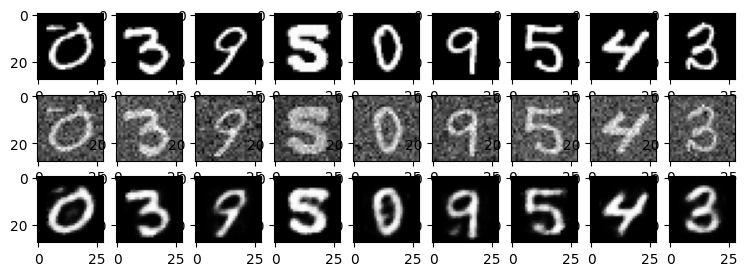

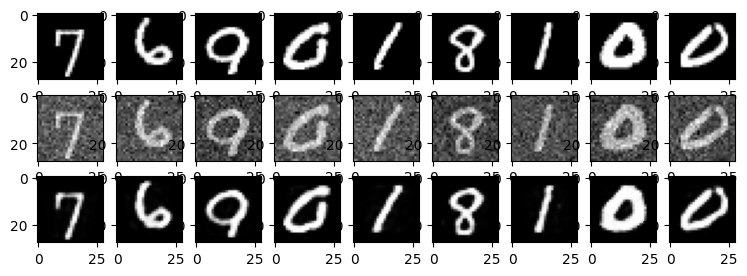

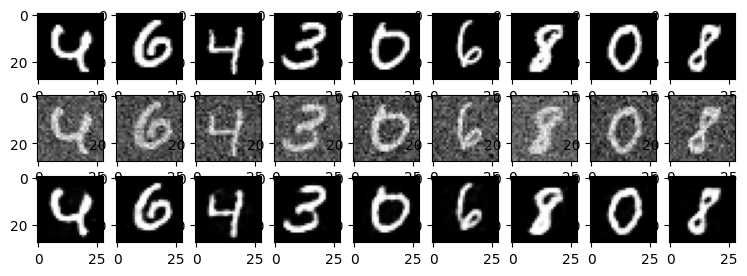

In [68]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 3))
    plt.gray()
    imgs = salida[k][1].detach().numpy()
    nois = salida[k][2].detach().numpy()
    recon = salida[k][3].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(3, 9, i+1)
        item = item.reshape(-1, 28,28)
        plt.imshow(item[0])
    
    for i, item in enumerate(nois):
        if i >= 9: break
        plt.subplot(3, 9, 9+i+1)
        item = item.reshape(-1, 28,28)
        plt.imshow(item[0])        
    
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(3, 9, 9+9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28)
        plt.imshow(item[0]) 

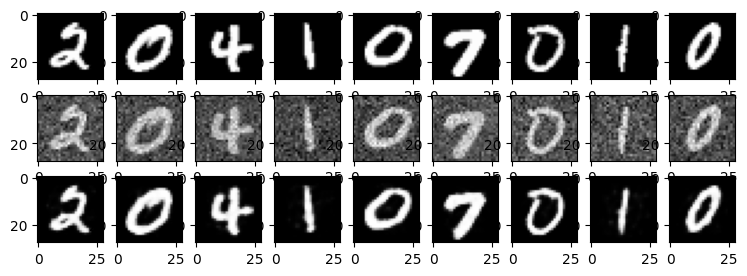

In [83]:
model.eval()

dataiter = iter(data_loader_valid)
images, labels = dataiter.__next__()

img = images[0]

plt.figure(figsize=(9, 3))
plt.gray()


for i, img in enumerate(images[:9]):
    with torch.no_grad():
        img2 = img.reshape(-1, 28*28)
        noise = add_noise(img2)
        pred = model(noise)
        recon = pred[0].detach().numpy()
        recon2 = recon.reshape(-1, 28,28)
        noise2 = noise.reshape(-1, 28,28)
        

        plt.subplot(3, 9, i+1)
        plt.imshow(img[0])
        
        plt.subplot(3, 9, i+1+9)
        plt.imshow(noise2[0])
        
        plt.subplot(3, 9, i+1+9+9)
        plt.imshow(recon2[0])

    

### Ejercicio 2: Hacer SuperResolución

In [3]:
class CNN_Modificada(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 14, 14
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # -> N, 32, 14, 14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=1) # -> N, 64, 7, 7
        
        )
        
        # N, 64, 7, 7
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # -> N, 1, 28, 28
            nn.Sigmoid()
        )
                
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
model = CNN_Modificada()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [6]:
num_epochs = 10
out_sr = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
         
        reduccion = nn.functional.interpolate(img, scale_factor=0.5, mode='bilinear', align_corners=False)
        
        optimizer.zero_grad()
        outputs = model(reduccion)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    out_sr.append((epoch, img, reduccion, outputs))


Epoch:1, Loss:0.0021
Epoch:2, Loss:0.0017
Epoch:3, Loss:0.0017
Epoch:4, Loss:0.0017
Epoch:5, Loss:0.0014
Epoch:6, Loss:0.0017
Epoch:7, Loss:0.0017
Epoch:8, Loss:0.0019
Epoch:9, Loss:0.0018
Epoch:10, Loss:0.0015


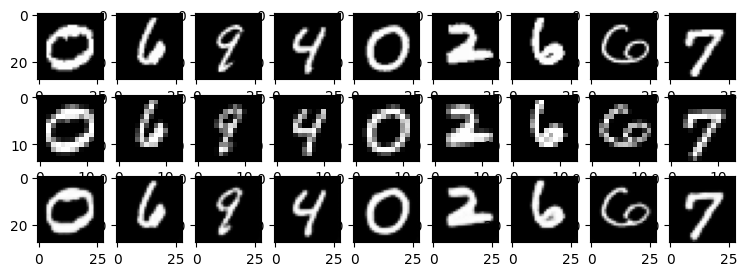

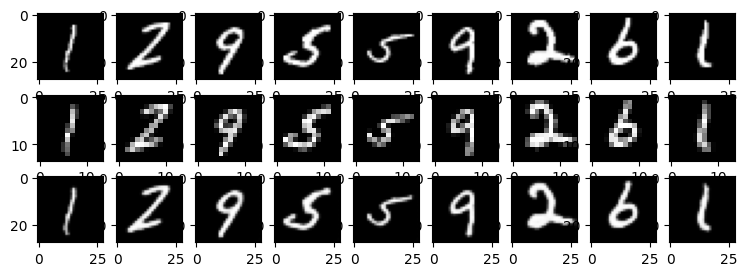

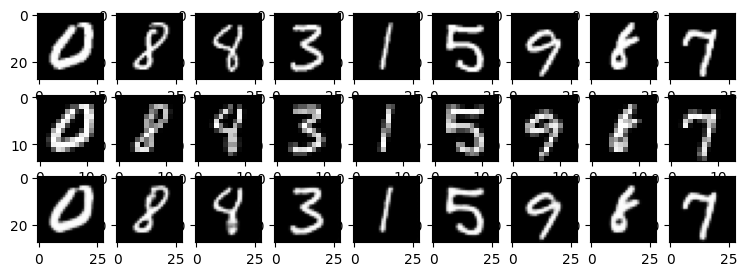

In [7]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 3))
    plt.gray()
    imgs = out_sr[k][1].detach().numpy()
    down_s = out_sr[k][2].detach().numpy()
    recon = out_sr[k][3].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(3, 9, i+1)
        # item: 1, 28, 28
        plt.imshow(item[0])
        
    for i, item in enumerate(down_s):
        if i >= 9: break
        plt.subplot(3, 9, 9+i+1)
        # item: 1, 28, 28
        plt.imshow(item[0])    
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(3, 9, 9+9+i+1) # row_length + i + 1
        # item: 1, 28, 28
        plt.imshow(item[0]) 

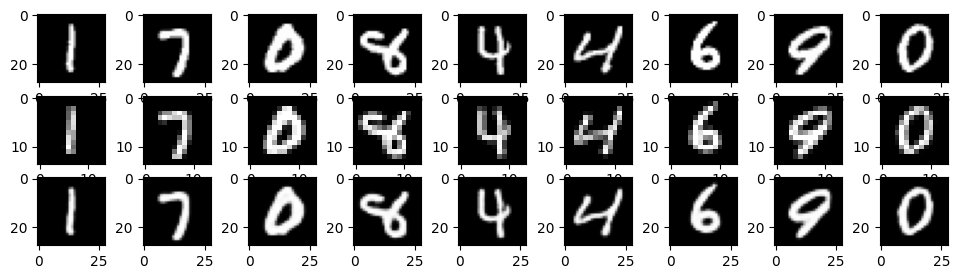

In [8]:
model.eval()

dataiter = iter(data_loader_valid)
images, labels = dataiter.__next__()

img = images[0]

plt.figure(figsize=(12, 3))
plt.gray()


for i, img in enumerate(images[:9]):
    with torch.no_grad():
        img = img.unsqueeze(0)
        
        img2 = nn.functional.interpolate(img, scale_factor=0.5, mode='bilinear', align_corners=False)
        pred = model(img2)
        recon = pred[0].detach().numpy()

        plt.subplot(3, 9, i+1)
        plt.imshow(img[0][0])
        
        plt.subplot(3, 9, i+1+9)
        plt.imshow(img2[0][0])

        plt.subplot(3, 9, i+1+9+9)
        plt.imshow(recon[0])
